Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [2]:
WELLS = ["VW1", "VW2"]              #wells the model considers
K_FOLDS = 10                        #number of folds used for K-Fold Validation
FRAC_THRESHOLD = 0.4                #probability threshold that implies a fracture
MODEL_HYPERPARAMETERS = {
        'objective' : 'binary:logistic',
        'seed' : 42,
        'max_depth': 25,            #maximum depth of individual decision trees
        'n_estimators' : 100,       #number of individual decision trees
        'learning_rate': 0.08,      #learning rate
        'subsample' : 0.67,         #fraction of training samples used for training each tree
        'colsample_bytree' : 0.69,  #fraction of features used for training each tree
        'min_child_weight' : 3.7,   #minimum sum needed to be considered a leaf node
        'reg_alpha' : 0.53,
        'reg_lambda' : 0.07
      }

FORMATIONS = [                      #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/XGBRegress/"

Imports

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, \
mean_absolute_error, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, \
 RandomizedSearchCV, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from random import randint, uniform

import matplotlib.pyplot as plt
import math

import seaborn
import joblib

Retrieve Data and Labels

In [6]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

VW1 : Shape of inputs= (3999, 24)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 25)
VW2 : Shape of inputs= (3413, 24)
VW2 : Shape of labels= (9130, 2)
VW2 : Shape of merged= (3413, 25)
Num features: 22


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [7]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [8]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [9]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
   {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [10]:
def print_metrics(accuracy, precision, recall, f1):
  """
  Print accuracy, precision, recall, and f1 scores.
  """
  print(f"Average accuracy is {(accuracy * 100).round(2)}%")
  print(f"Average precision is {(precision * 100).round(2)}%")
  print(f"Average recall is {(recall * 100).round(2)}%")
  print(f"Average f1 is {(f1 * 100).round(2)}%")

In [11]:
def plot_depth_probabilities(curr_well, depths, y_pred, y_pred_rounded):
  """
  Plots predicted probability of a fracture at each depth.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth")
  plt.title(curr_well + " Predictions")
  plt.barh(depths, y_pred, color="red", label="Probability")
  plt.barh(depths, y_pred_rounded, color="blue", label="Rounded")
  plt.xlim(-0.1,1.1)
  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.gca().invert_yaxis()
  plt.legend()
  plt.show()

In [12]:
def plot_depths_with_labels(curr_well, depths, y_preds, test_labels):
  """
  Plots the depths that are predicted to contain fractures alongside the
  actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  title = curr_well + "(Predictions | Truth)"
  plt.title(title)
  y_preds = [-y for y in y_preds]
  plt.barh(depths, y_preds, color="blue")
  plt.barh(depths, test_labels, color="gray")

  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_XGBClassPlot.png', format='png', dpi=1200)
  plt.show()

In [13]:
def get_feat_import(X_train):
  """
  Calculates the importance scores of features in a dataset (calculated by
  incorporating the number of times the feature was split on + how influential
  that split was). Returns the features in descending importance order and their
  associated importance scores.
  """
  xgb_regressor = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  importance_scores = xgb_regressor.feature_importances_

  # Sort feature importance scores and corresponding feature names
  sorted_indices = np.argsort(importance_scores)[::-1]
  sorted_features = X_train.columns[sorted_indices]

  return sorted_features, importance_scores[sorted_indices]

Train/Test Model Functions

In [19]:
def train_model(X, y):
  """
  Constructs an XBoost regression model (outputs float), trains the model
  using the trainset (employs K-Fold cross validation and a mean squared error
  loss function), and prints the model's training performance.
  """
  hyperparameters = MODEL_HYPERPARAMETERS

  #helps avoid overfitting by prioritizing minority class
  num_pos = sum(y)
  num_neg = len(y) - num_pos
  hyperparameters['scale_pos_weight'] = num_neg / num_pos
  print("\nResults for training:")
  xgb_regressor = xgb.XGBRegressor(**hyperparameters)

  #train model using K-Fold cross validation
  #cv=KFold(n_splits=k, shuffle=True)
  cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True) #stratified sampling
  results = cross_validate(xgb_regressor, X, y, cv=cv,
                           scoring='neg_mean_squared_error')
  xgb_regressor.fit(X, y)

  #Calculate and print mean squareed error
  mse = -np.mean(results['test_score'])  # Mean Squared Error
  print("Mean Squared Error:", mse)

  joblib.dump(xgb_regressor, MODEL_DUMP_PATH + "model.joblib")

In [25]:
def test_model(X, y):
  """
  Apply trained XGBoost regression model to previously unseen test data,
  print results, and return predictions.
  """
  #load trained model and make predictions with unseen test data
  xgb_regressor = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  y_preds = xgb_regressor.predict(X)

  #normalize y_pred and set threshold
  y_pred_max = max(1, max(y_preds))
  y_preds = y_preds / y_pred_max
  y_pred_rounded = []
  for y_pred in y_preds:
    if y_pred < FRAC_THRESHOLD:
      y_pred_rounded.append(0)
    else:
      y_pred_rounded.append(1)

  #display model's current performance
  accuracy = accuracy_score(y, y_pred_rounded)
  precision = precision_score(y, y_pred_rounded)
  recall = recall_score(y, y_pred_rounded)
  f1 = f1_score(y, y_pred_rounded)
  print_metrics(accuracy, precision, recall, f1)
  return y_preds, y_pred_rounded

Run Model on All Combination of Wells


Training on ['VW2'],   testing on VW1

Results for training:
Mean Squared Error: 0.058212709016471444

Results for training:
Average accuracy is 99.62%
Average precision is 97.06%
Average recall is 100.0%
Average f1 is 98.51%

Results for testing:
Average accuracy is 77.67%
Average precision is 28.68%
Average recall is 38.31%
Average f1 is 32.81%


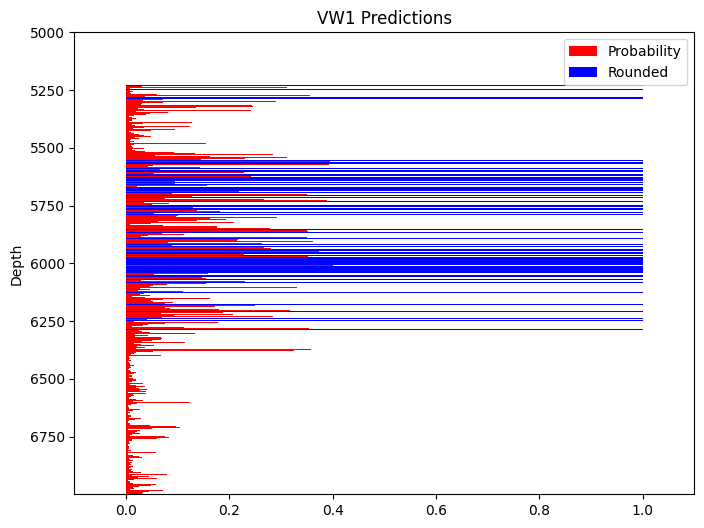

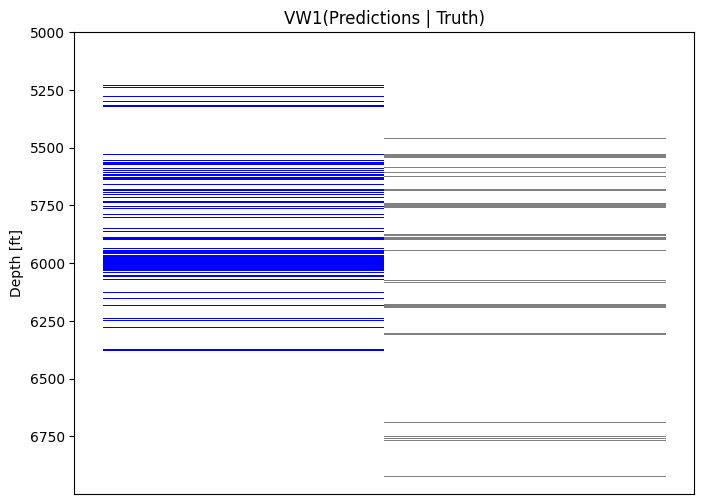


Training on ['VW1'],   testing on VW2

Results for training:
Mean Squared Error: 0.04611809521700287

Results for training:
Average accuracy is 99.42%
Average precision is 96.11%
Average recall is 100.0%
Average f1 is 98.02%

Results for testing:
Average accuracy is 80.93%
Average precision is 13.96%
Average recall is 10.02%
Average f1 is 11.67%


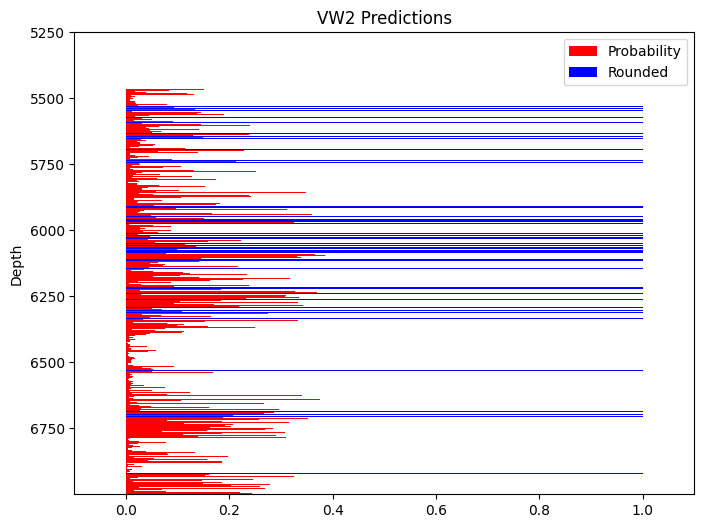

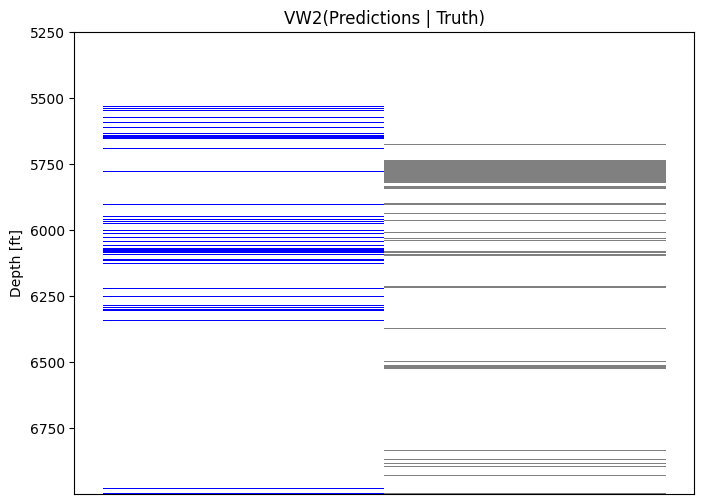

In [26]:
import_feats = {}
for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  testset = datasets[curr_well]
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
   testing on {curr_well}")
  trainsets = [datasets[well] for well in WELLS if well != curr_well]
  trainset = pd.concat(trainsets)
  test_depths = testset["DEPT"] #save for plotting

  ### optional undersampling of majority class
  #trainset = balance_dataset(trainset)

  X_train = np.array(trainset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_train = np.array(trainset["HAS_FRAC"])
  X_test = np.array(testset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_test = np.array(testset["HAS_FRAC"])

  ### optional data preprocessing steps
  X_train, X_test = normalize(X_train, X_test)
  #X_train, X_test = apply_PCA(X_train, X_test)

  ### train/test model and display results
  train_model(X_train, y_train)
  print("\nResults for training:")
  test_model(X_train, y_train)
  print("\nResults for testing:")
  y_pred, y_pred_rounded = test_model(X_test, y_test)

  plot_depth_probabilities(curr_well, test_depths, y_pred, y_pred_rounded)
  plot_depths_with_labels(curr_well, test_depths, y_pred_rounded, y_test)

  ### keep track of feature importance scores
  feats, scores =  get_feat_import(trainset.drop(
                                          columns=["HAS_FRAC", "FORM", "DEPT"]))
  import_feats[curr_well] = [feats, scores]

Print Important Features


Important Features for Well VW1:
1. XIWATER: 0.08995787799358368
2. DTSM: 0.07510307431221008
3. PYRITE: 0.06143753603100777
4. CHLORITE: 0.052730169147253036
5. RLA5: 0.04976065456867218
6. BOUND_WATER: 0.04838541895151138
7. RLA4: 0.04714887961745262
8. DTCO: 0.04668442904949188
9. DOLOMITE: 0.04404291883111
10. PIGE: 0.043911948800086975
11. ILLITE: 0.04285745695233345
12. RLA2: 0.04206223413348198
13. RHOZ: 0.04038470983505249
14. KSDR_PY: 0.040178973227739334
15. K-FELDSPAR: 0.03929070010781288
16. KAOLINITE: 0.03836413472890854
17. QUARTZ: 0.03701227158308029
18. RXOZ: 0.03588098660111427
19. N-FELDSPAR: 0.03495277836918831
20. UWATER: 0.03428792580962181
21. RLA3: 0.028430217877030373
22. XWATER: 0.0271347314119339


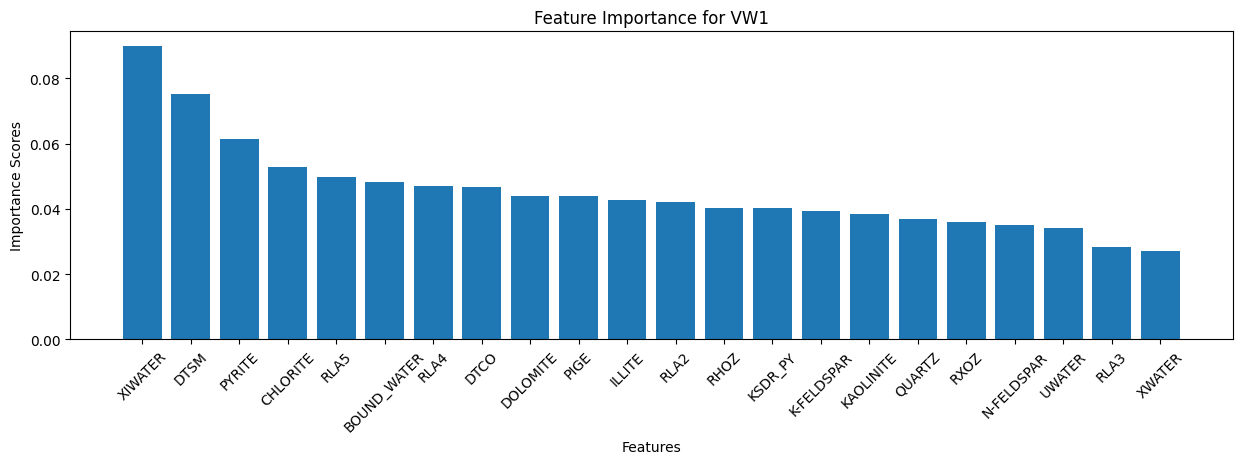

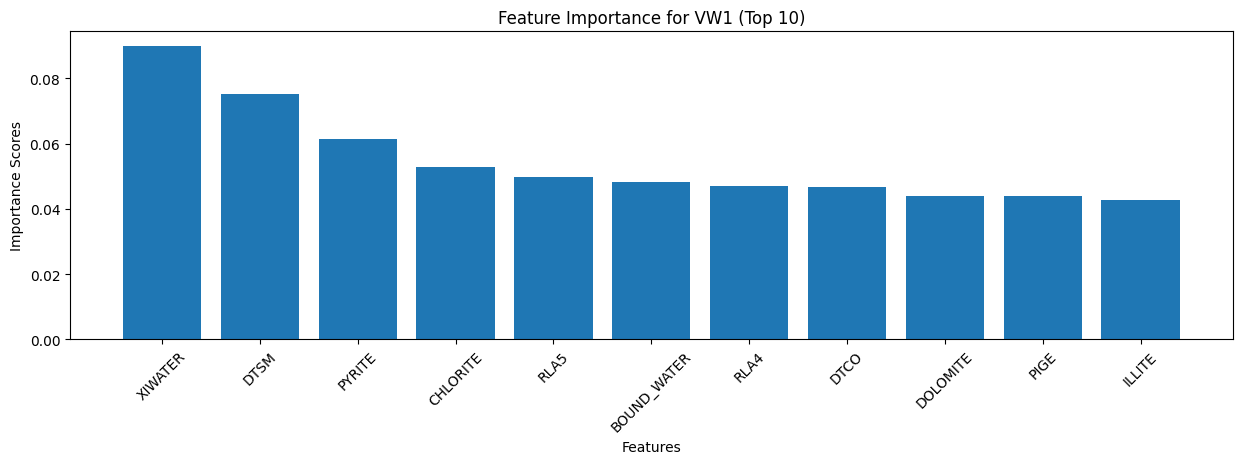


Important Features for Well VW2:
1. DTCO: 0.13592706620693207
2. DTSM: 0.08047410845756531
3. RLA2: 0.06470382213592529
4. KAOLINITE: 0.050672587007284164
5. K-FELDSPAR: 0.04905027151107788
6. RLA4: 0.046431634575128555
7. ILLITE: 0.04405427351593971
8. RLA3: 0.04356019198894501
9. QUARTZ: 0.04307551681995392
10. CHLORITE: 0.040545620024204254
11. BOUND_WATER: 0.040041834115982056
12. RXOZ: 0.03601183369755745
13. DOLOMITE: 0.035298388451337814
14. RLA5: 0.035048168152570724
15. PYRITE: 0.034503448754549026
16. RHOZ: 0.033794499933719635
17. XIWATER: 0.03301602602005005
18. XWATER: 0.032698854804039
19. KSDR_PY: 0.03258291631937027
20. UWATER: 0.0297993253916502
21. N-FELDSPAR: 0.02967117726802826
22. PIGE: 0.029038425534963608


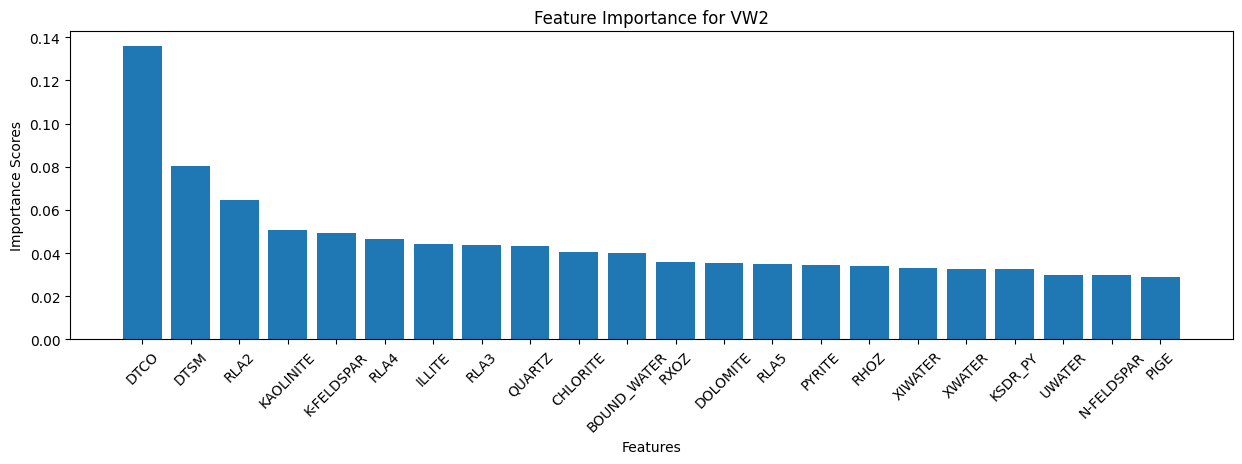

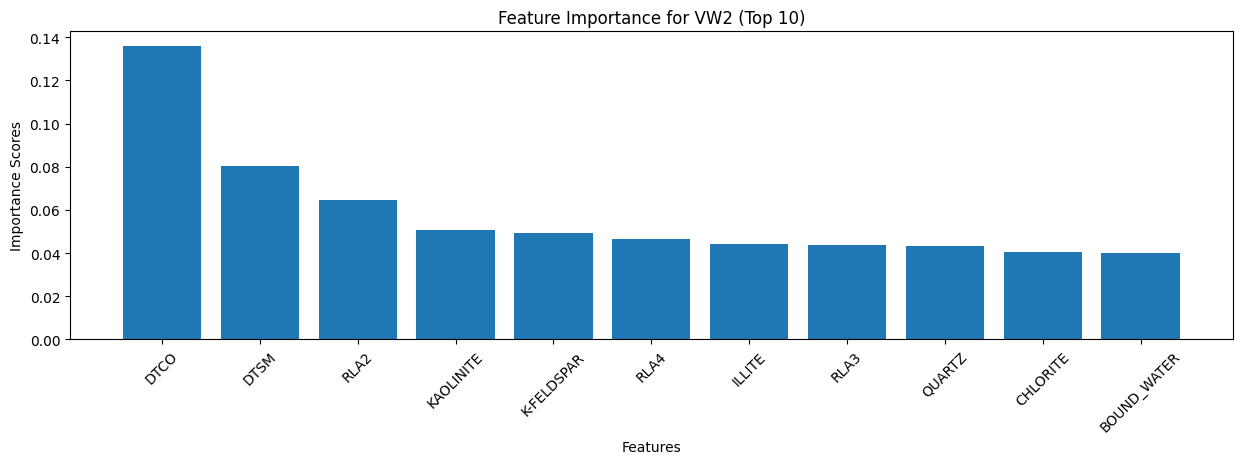

In [27]:
for well in WELLS: #iterate through relevant wells
  sorted_features, importance_scores = import_feats[well]

  # Print feature importance scores and corresponding feature names
  print(f"\nImportant Features for Well {well}:")
  counter = 1
  for feature, score in zip(sorted_features, importance_scores):
    print(f"{counter}. {feature}: {score}")
    counter += 1

  #Plot feature importance for each well
  plt.figure(figsize=(15, 4))
  plt.title('Feature Importance for ' + well)
  plt.bar(range(len(importance_scores)), importance_scores,
                                         tick_label=sorted_features)
  plt.xlabel('Features')
  plt.ylabel('Importance Scores')
  plt.xticks(rotation=45)
  plt.show()

  #Plot feature importance for each well (top 10)
  plt.figure(figsize=(15, 4))
  plt.title('Feature Importance for ' + well + " (Top 10)")
  plt.bar(range(11), importance_scores[:11], tick_label=sorted_features[:11])
  plt.xlabel('Features')
  plt.ylabel('Importance Scores')
  plt.xticks(rotation=45)
  plt.show()